# 3. Hierarchical Models

We previously modelled tips for each day as completely independent of
any other day. Perhaps this implicit assumption is not correct. How
might we improve our tips model?

One idea: a hierarchical model where each day has a **hyper-prior**
that allows days to be **simultaneously** independent and related.

## 3.1 Sharing information, sharing priors

Hierarchical models are particularly useful when the data has a
natural hierarchy. Some examples are:

- Geographical regions (for example, cities, counties, and states)
- Students within schools
- Patients nested with hospitals
- Repeated measurements **on the same** individuals

In a hierarchical model, the parameters of the priors are themselves
drawn from another (prior) distribution (often called **hyperpriors**).
This structure allows groups to be different but also to share
information between groups while, at the same time, allowing
**differences between groups.**



In [1]:
# Perform our typical data science and PyMC imports

# Import cytoolz for data manipulation
import cytoolz.curried as ctc

# Import PyMC and supporting packages
import arviz as az
import pymc as pm
import preliz as pz

# Import other "data science" packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sympy.plotting.experimental_lambdify import experimental_lambdify
from torch.utils.model_dump import hierarchical_pickle

In [2]:
# Some additional initialization (for consistency)
az.style.use('arviz-grayscale')
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

# Set a consistent random seed
rng = np.random.default_rng(seed=123)

## 3.2 Hierarchical shifts

Proteins are molecules formed by 20 units call amino acids. And each
amino acid can appear in a protein zero or more times.

One way to study proteins is nuclear magnetic resonance. This technique
allows us to measure different quantities such as the chemical shift.

Suppose we want to compare a theoretical method of computing chemical
shifts with experimental observations. This experiment allows us to
evaluate the theory.

Luckily, someone has already performed both the theoretical calculations
and the experiments. We just need to perform the comparison.

The data frame, indicated by the variable, `cs_data`, has four columns:

- A code that identifies the protein
- A second column that names the amino acid
- The third column contains the theoretical chemical shift values
- The fourth column has the experimental values


In [3]:
# Import the data of interest
cs_data = pd.read_csv('data/chemical_shifts_theo_exp.csv')
cs_data

ID   aa   theo    exp        cat
0     1BM8  ILE  61.18  58.27  Non-Polar
1     1BM8  TYR  56.95  56.18      Polar
2     1BM8  SER  56.35  56.84      Polar
3     1BM8  ALA  51.96  51.01    Special
4     1BM8  ARG  56.54  54.64    Charged
...    ...  ...    ...    ...        ...
1771  1KS9  LYS  55.79  57.51    Charged
1772  1KS9  ARG  58.91  59.02    Charged
1773  1KS9  LYS  59.49  58.92    Charged
1774  1KS9  GLU  59.48  58.36    Charged
1775  1KS9  SER  58.07  60.55      Polar

[1776 rows x 5 columns]

In [4]:
# The difference (`diff`) is our measure of interest
diff = cs_data.theo - cs_data.exp

# Encode the amino acid name as categories
cat_encode = pd.Categorical(cs_data['aa']) # amino acid
idx = cat_encode.codes

# Use the categories as "coordinates"
coords = {'aa': cat_encode.categories}

In [5]:
diff

0       2.91
1       0.77
2      -0.49
3       0.95
4       1.90
        ... 
1771   -1.72
1772   -0.11
1773    0.57
1774    1.12
1775   -2.48
Length: 1776, dtype: float64

Now that we have the data, how should we proceed? One option: take the
empirical differences and fit a Gaussian or Student's T model. Because
amino acids are a "family," it would make sense to assume they are all
the same and estimate a single Gaussian for **all** the differences.

But one may argue: Is not each amino acid different from all the others?
Biologically, yes. Chemically, yes, but I am uncertain how different. If
we treat each amino acid differently from all the others, will my model
of reality be better than a single model?

Here are some of the consequences:

| Single model                        | Multiple models                               |
|-------------------------------------|-----------------------------------------------|
| Our estimates will be more accurate | More detailed analysis but with less accuracy |

What should we do?

When in doubt, do **everything**! We will build a hierarchical model.
This choice allows estimates at a group level with a "restriction"
that all items belong to a larger group or population.

However, to see the difference, we will actually build **two models**.

- A non-hierarchical (unpooled) model
- A hierarchical model

For reference, the unpooled model is essentially the same as our
`comparing_groups` model from [chapter 2](./ch02-prog-probabilistically.ipynb).

In [6]:
# Our non-hierarchical model
with pm.Model(coords=coords) as cs_nh: # chemical shifts non-hierarchical
    mu = pm.Normal('mu', mu=00, sigma=10, dims='aa')
    sigma = pm.HalfNormal('sigma', sigma=10, dims='aa')
    y = pm.Normal('y', mu=mu[idx], sigma=sigma[idx], observed=diff)

    idata_cs_nh = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now we will build the hierarchical version of the model.

We add **two** hyperpriors:

- One for the mean of $\mu$
- One for the standard deviation of $\mu$

We leave $\sigma$ **without** hyperpriors; that is, we assume that the
variance between observed and theoretical values should be unique
**for each group.**. This choice is a **modelling choice**. Remember
that you may face a problem in which independent variances does not
seem reasonable. In this situation, feel free to add a hyperprior
for $\sigma$.

In [7]:
with pm.Model(coords=coords) as cs_h:
    # Hyper priors
    mu_mu = pm.Normal('mu_mu', mu=0, sigma=10)
    mu_sd = pm.HalfNormal('mu_sd', sigma=10)

    # Priors
    mu = pm.Normal('mu', mu=mu_mu, sigma=mu_sd, dims='aa')
    sigma = pm.HalfNormal('sigma', sigma=10, dims='aa')

    # Likelihood
    y = pm.Normal('y', mu=mu[idx], sigma=sigma[idx], observed=diff)
    idata_cs_h = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sd, mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


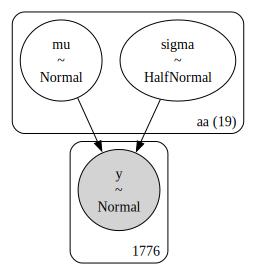

In [8]:
pm.model_to_graphviz(cs_nh)

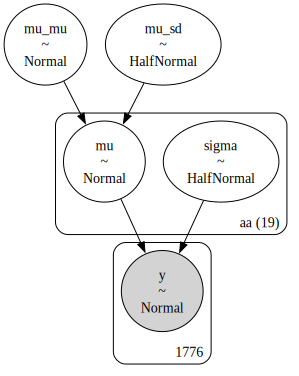

In [9]:
pm.model_to_graphviz(cs_h)


We can compare results using the `plot_forest` function of `ArviZ`.
We can pass more than one model to this function.

Plotting multiple models is useful when we want to compare the values
of parameters from different models - like the current example.

The plot includes both the 94% HDI and the inter-quartile range. The
vertical dashed line is the global mean according to the hierarchical
model. This value is close to zero which is expected for theoretical
values faithfully representing experimental ones.

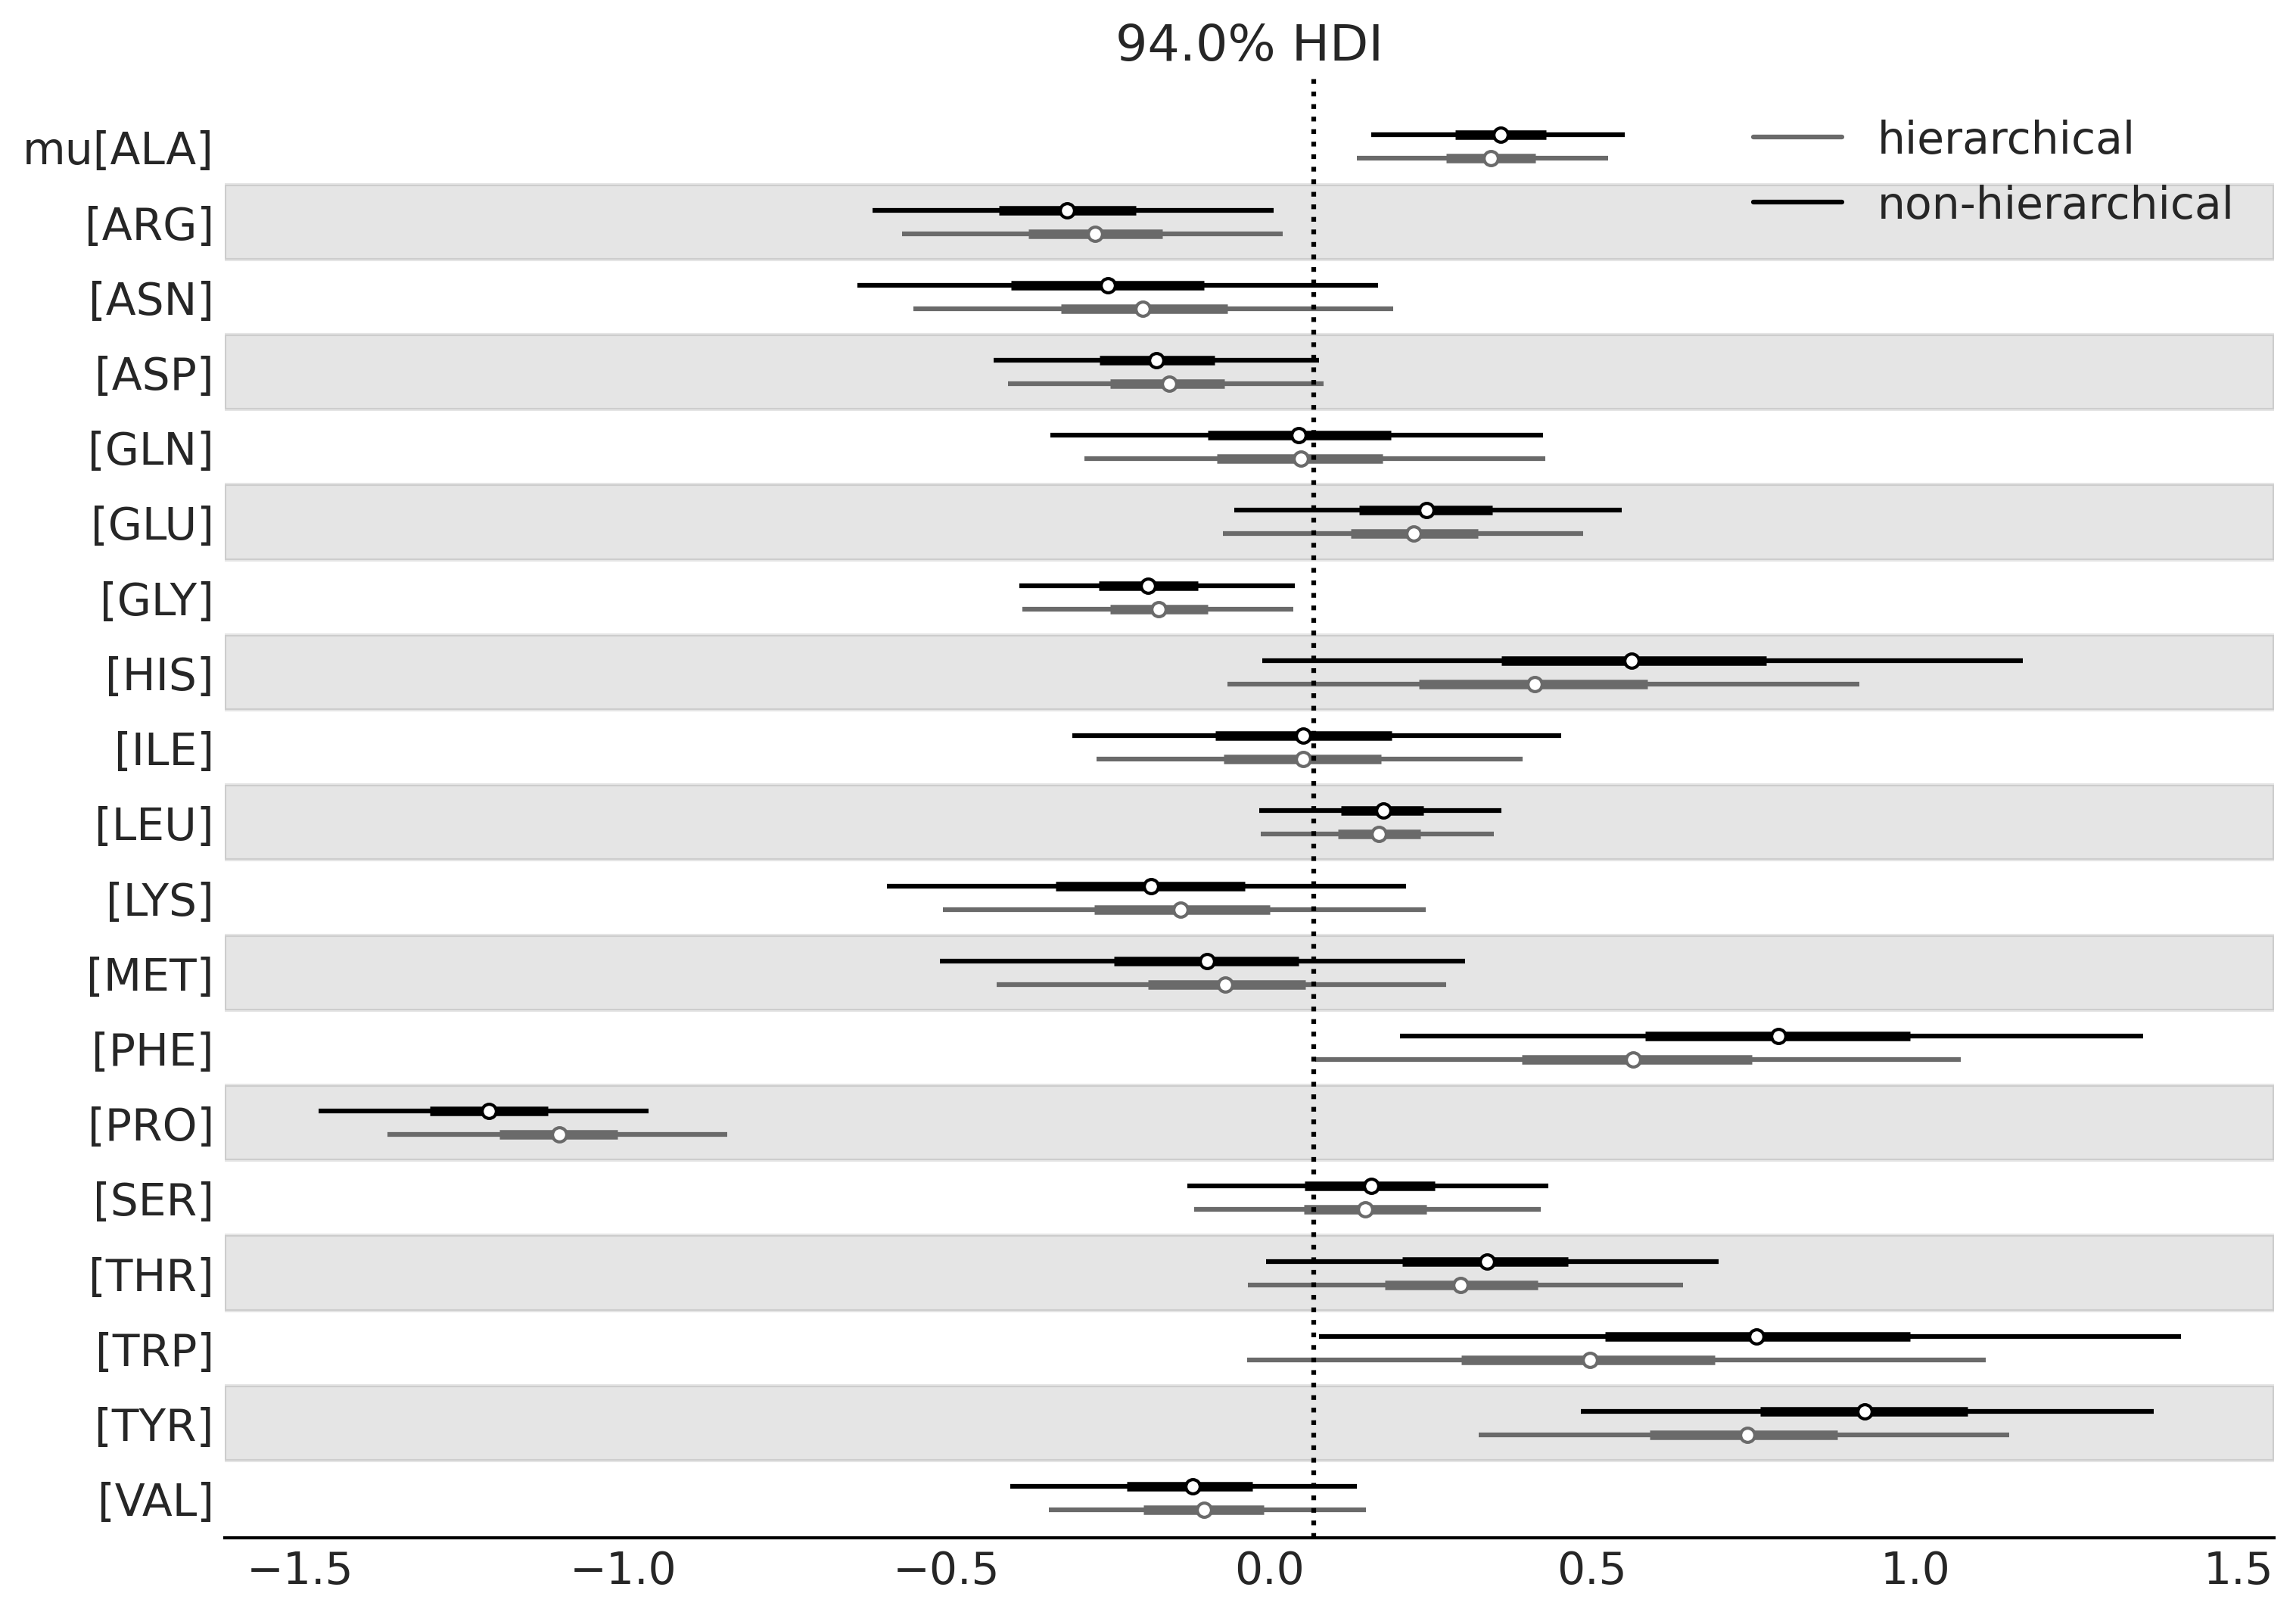

In [10]:
axes = az.plot_forest(
    [idata_cs_nh, idata_cs_h],
    model_names=['non-hierarchical', 'hierarchical'],
    var_names='mu',
    combined=True,
    r_hat=False,
    ess=False,
    figsize=(10, 7),
    colors='cycle',
)
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['mu_mu'].mean(),
               *y_lims,
               color='k',
               ls=':')
plt.show()

The most relevant part of this plot is that the estimates from the
hierarchical model are pulled toward the partially pooled mean;
equivalently, they are shrunken in comparison to the unpooled estimates.
Additionally, the effect is more pronounced for the groups farther away
from the mean (such as "PRO"). That uncertainty is on par with or
smaller than the uncertainty from the non-hierarchical model. The
estimates are partially pooled because we have one estimate for each
group, but estimates for individual groups restrict each other through
the hyperprior. Therefore, we get an intermediate situation between
having a single group with all the chemical shifts together and
having 20 separate groups, one per amino acid.

## 3.3 Water quality

Suppose we want to study the quality of water in a city. We take samples
in a number of neighborhoods.

We have two options for analyzing this data:

- Study each neighborhood as a **separate** entity
- Pool all the neighborhood data together and estimate the water quality
for the city as a whole.

This procedure is a recurring pattern:

- The first option allows a more detailed study of the problem
- The second option, because the amount of data is larger, is more accurate.

But we have a third option: build a hierarchical model!

To learn about hierarchical models in this scenario, we will
**simulate data**. The advantage of simulated data is that it allows us
to better understand our process (because, in theory, we
**know the answer**).

In our synthetic scenario, we imagine that:

- We collect water from three different regions of the system
- We measure the lead content of the collected water
- We encode "safe" (1 or `True`) and "unsafe" (0 or `False`) using
recommendations from the World Health Organization.

This scenario is a very simple scenario. In a more realistic scenario,
we would have a continuous measurement of lead concentrations and
probably many more samples.

The following code generates our synthetic data.

In [11]:
# Generate synthetic data
N_samples = [30, 30, 30] # number of samples
G_samples = [18, 18, 18] # number of good samples
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)

# Perhaps `cytoolz` might simplify this code
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0],
                          [G_samples[i], N_samples[i] - G_samples[i]]))

The model for this problem is similar to the model we used for the
coin problem except for two important features:

- We will define **two** hyperpriors that influence the Beta prior
- Instead of setting hyperpriors on the parameters, $\alpha$ and
$\beta$, we will define the Beta distribution in terms of $\mu$ and
$\nu$. (The parameter, $\nu$, is the concentration or precision of he
Beta distribution.)

The precision is an analog (not equal to) the inverse of the standard
deviation; the larger the value of $\nu$, the ***more** concentrated
is the Beta distribution.

In statistical notation our model is:

$$
\begin{gather}
\mu \sim Beta(\alpha_{\mu}, \beta_{\mu}) \\
\nu \sim \mathcal{HN(\sigma_{\nu})} \\
\sigma_{i} \sim Beta(\mu, \nu) \\
y_{i} \sim Bernoulli(\theta_{i})
\end{gather}
$$

We use the subscript $\mathcal{i}$ to indicate that the model has
groups with different values for some of the parameters. The following
Kruschke diagrams show an additional level compared to the diagrams
for the previous models.

For this new model, we parameterize the Beta prior distribution in
terms of $\mu$ and $\nu$ instead of $\alpha$ and $\beta$. This choice
is common in Bayesian statistics. We make this choice because $\mu$
and $\nu$ are more intuitive than $\alpha$ and $\beta$.

In [12]:
# Let's write the model in PyMC.
with pm.Model() as model_h:
    # hyperpriors
    mu = pm.Beta('mu', 1, 1)
    nu = pm.HalfNormal('nu', 10)

    # prior
    theta = pm.Beta('theta', mu=mu, nu=nu, shape=len(N_samples))

    # likelihood
    y = pm.Bernoulli('y', p = theta[group_idx], observed=data)

    idata_h = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


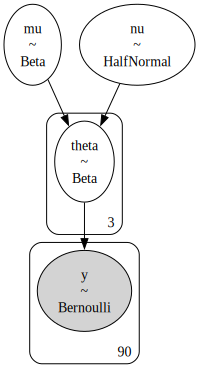

In [13]:
# Here are the Kruscke diagrams
pm.model_to_graphviz(model_h)

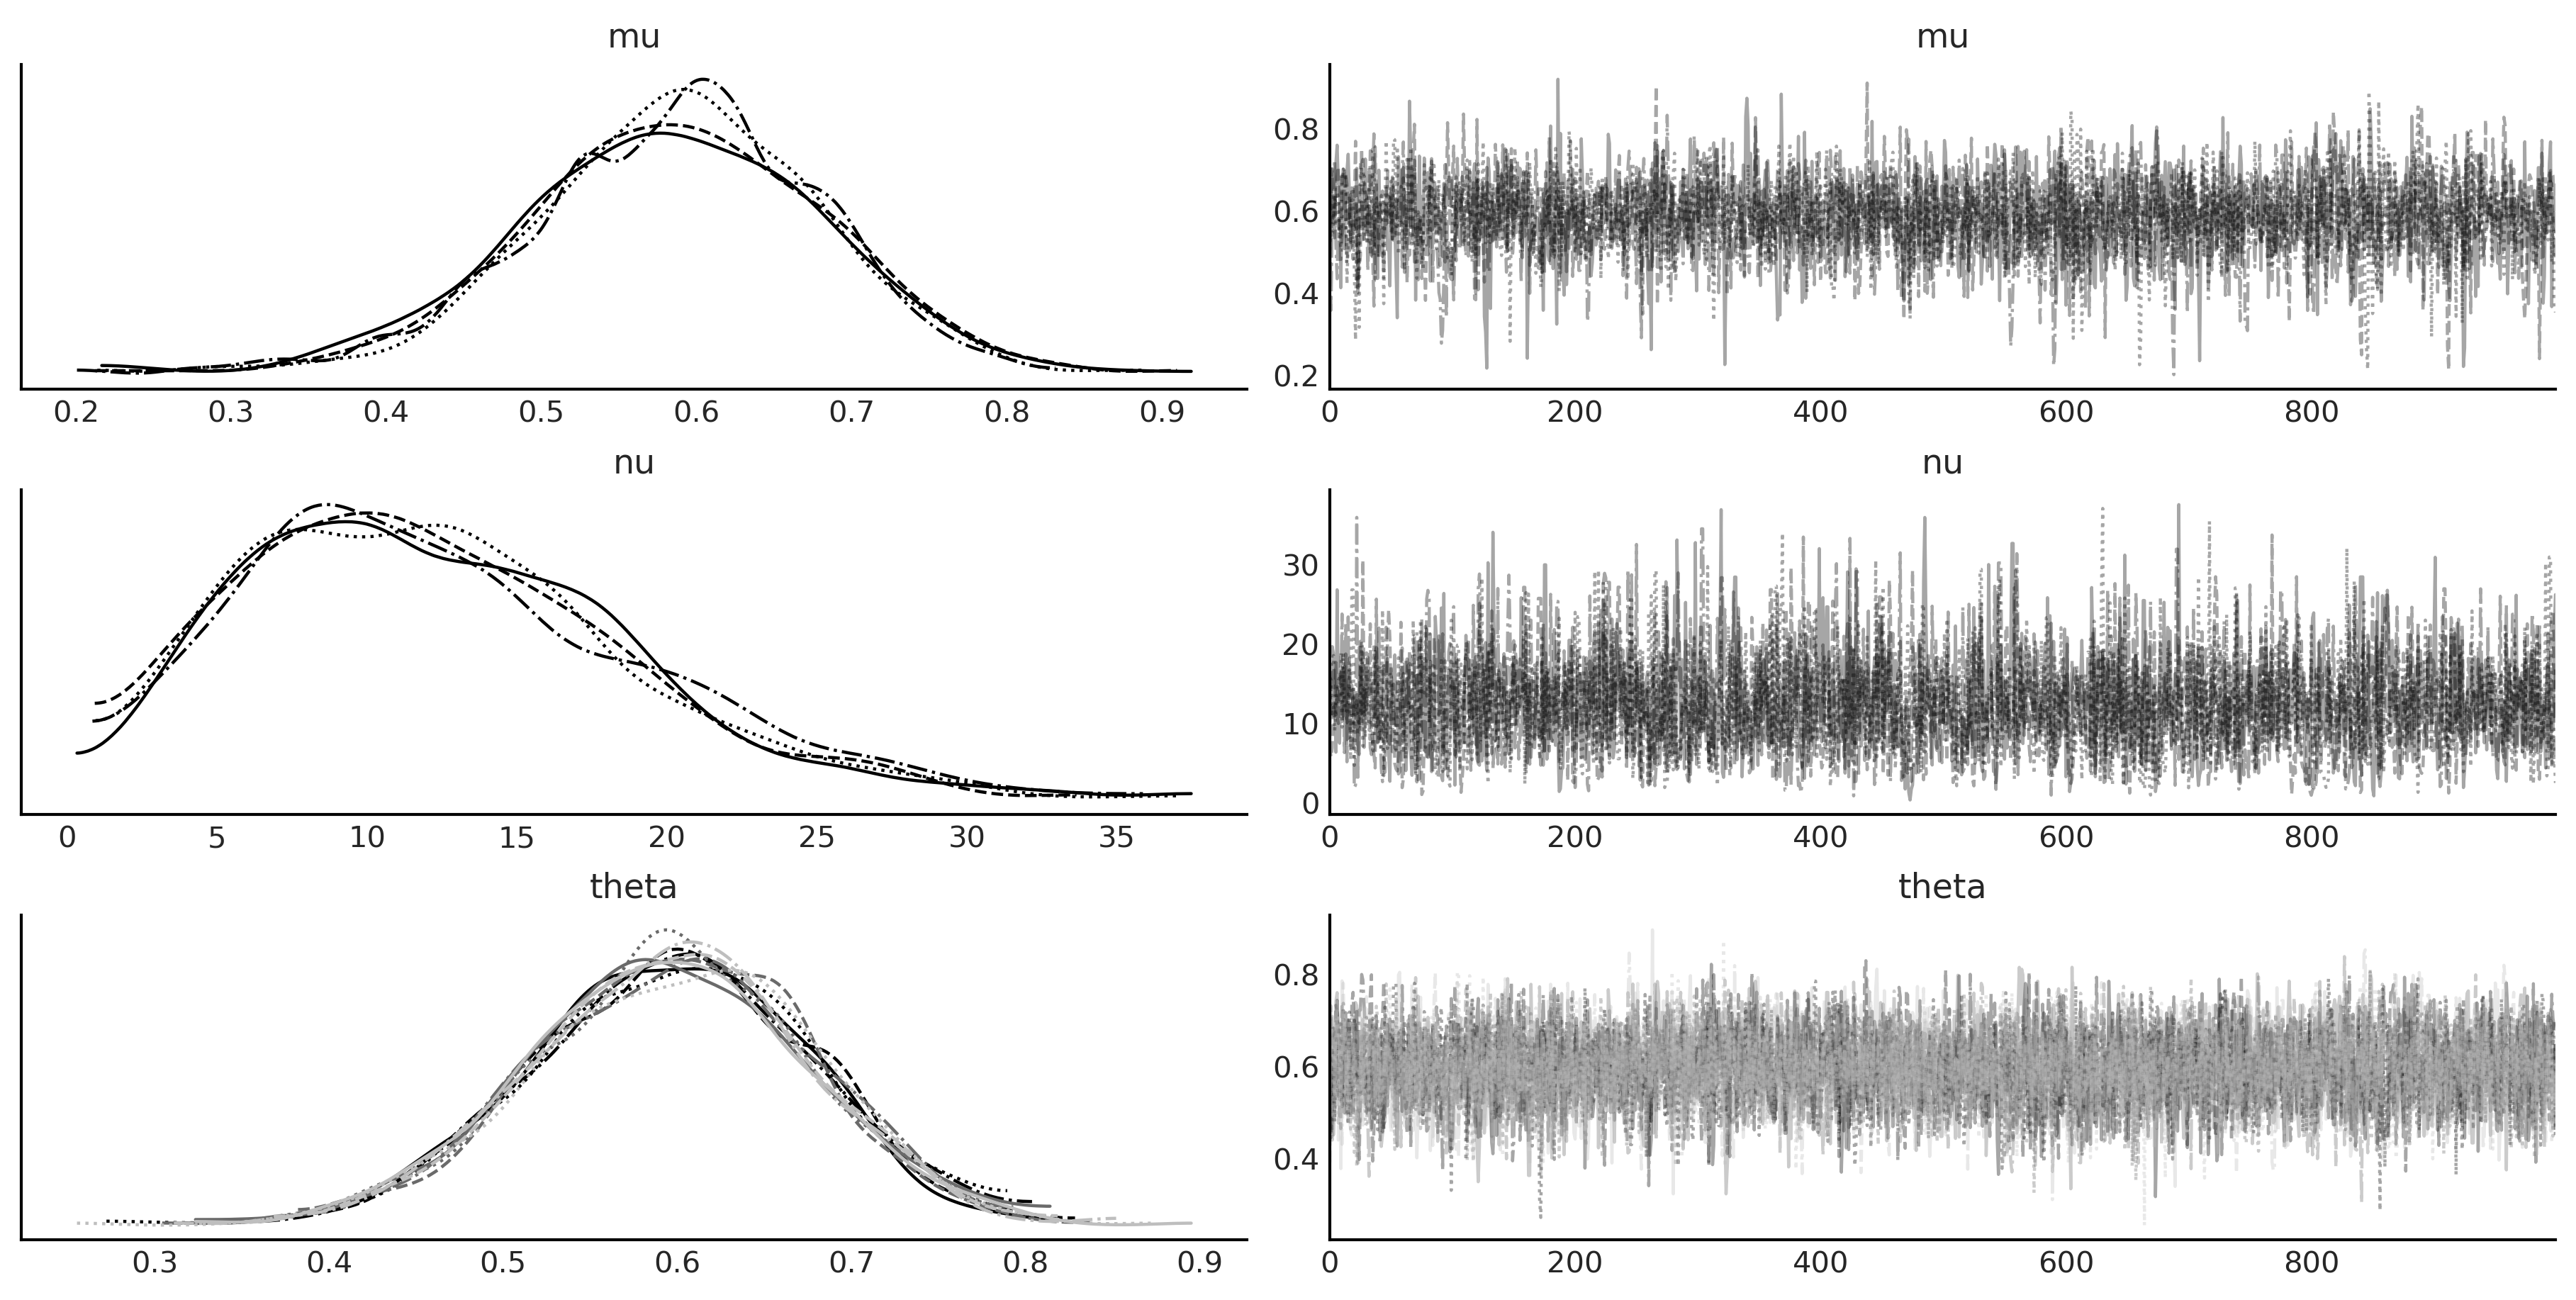

In [14]:
az.plot_trace(idata_h)
plt.show()

In [15]:
summary_g_18 = az.summary(idata_h)

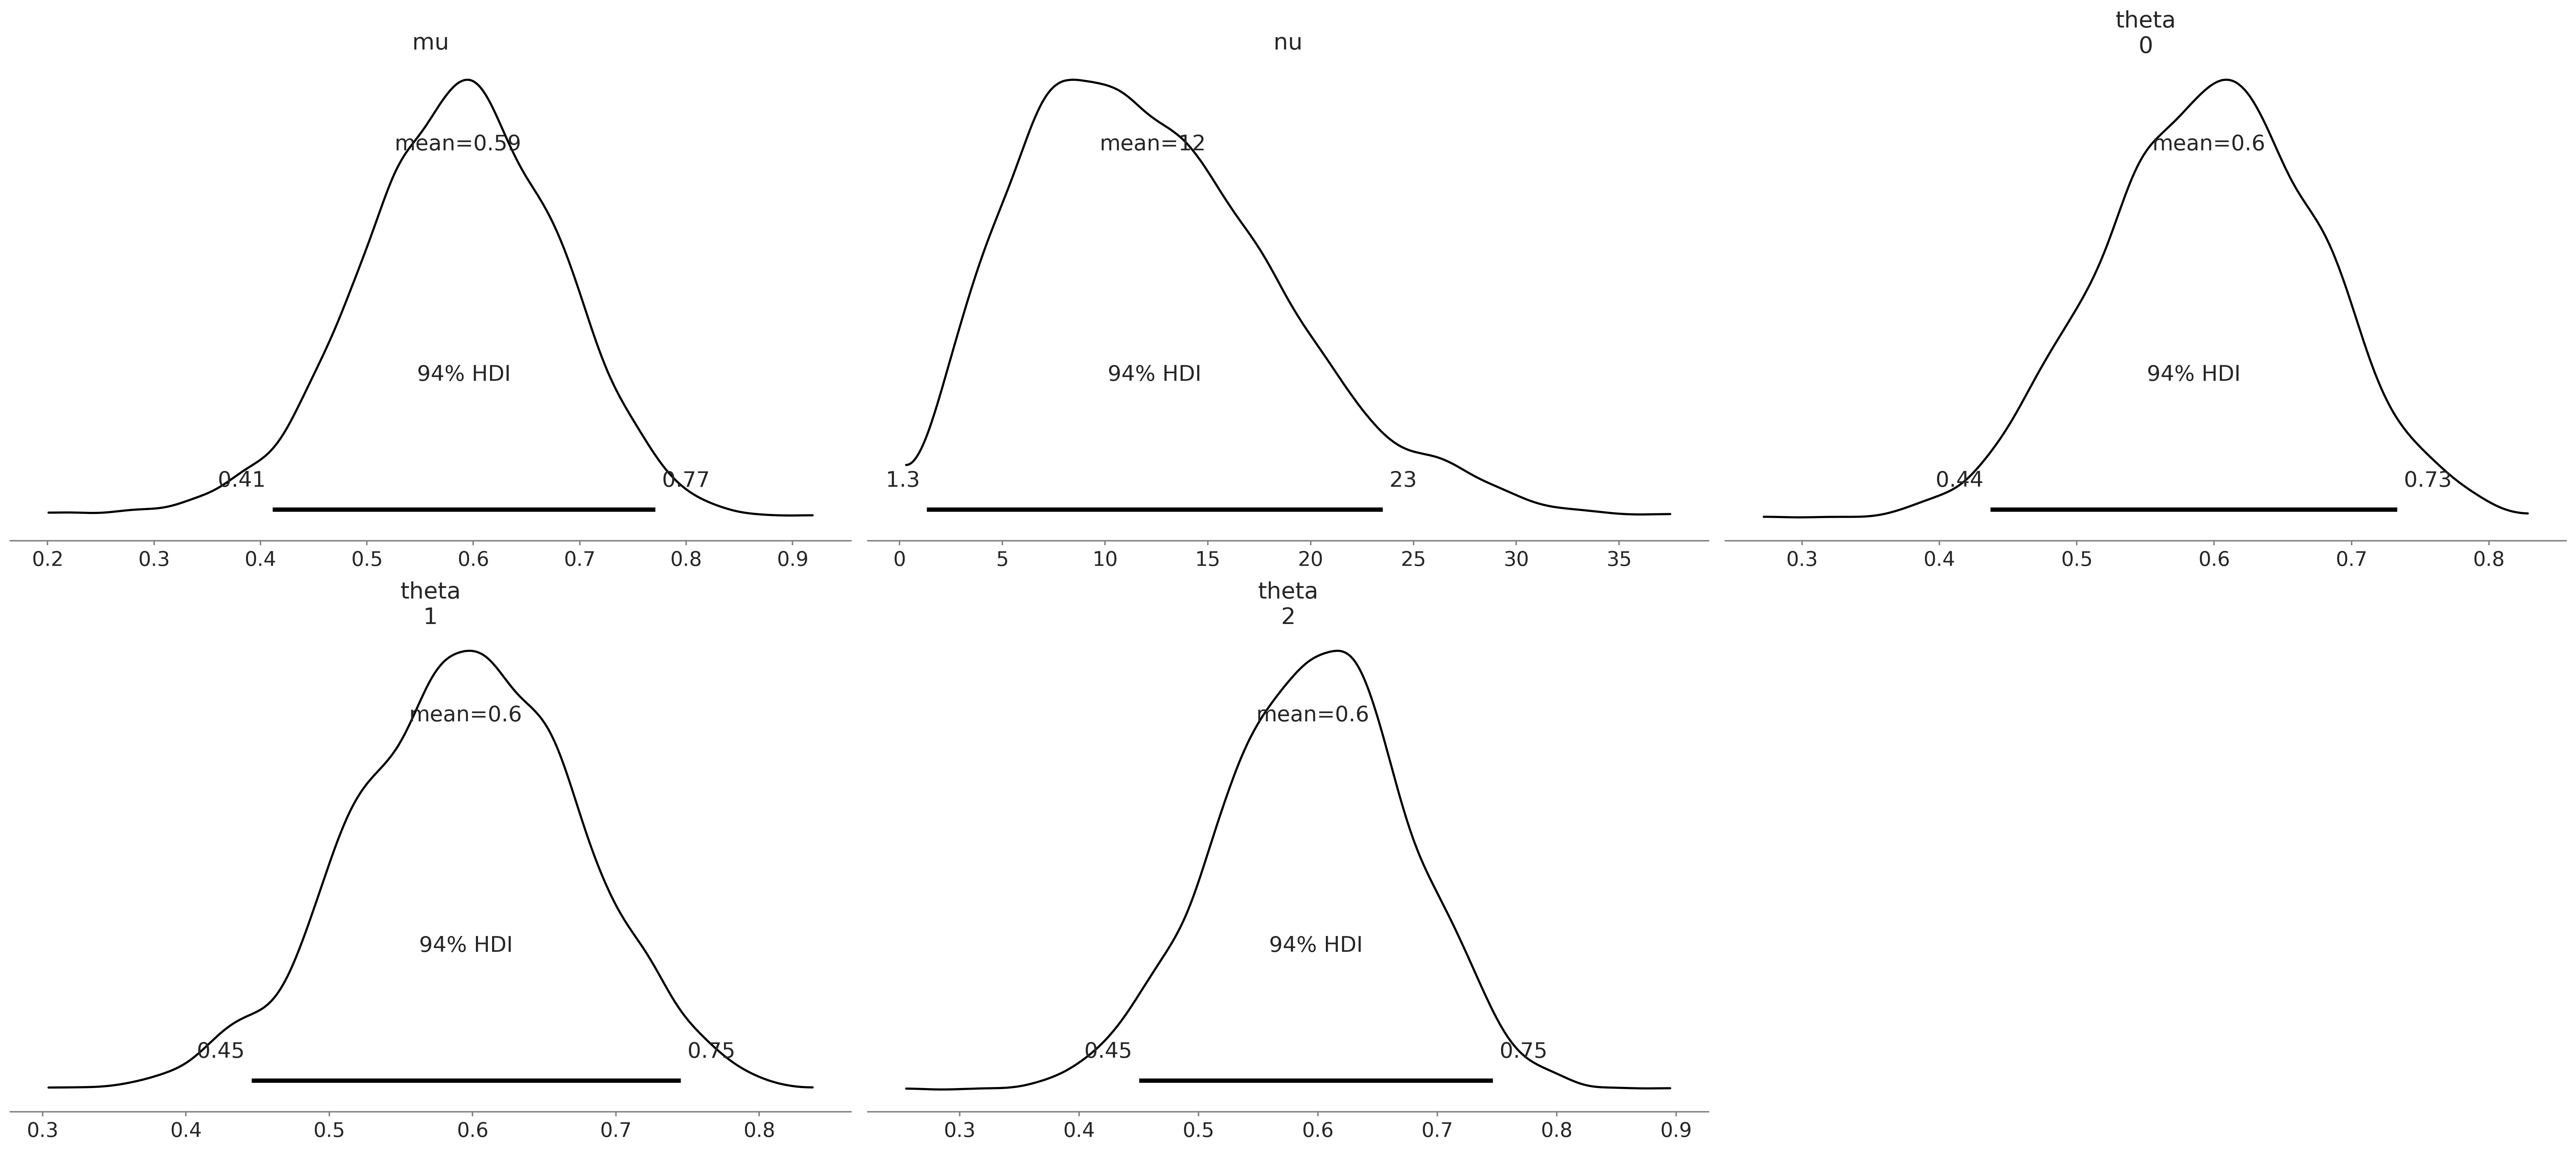

In [16]:
az.plot_posterior(idata_h)
plt.show()

## 3.4 Shrinkage

Please join me in a brief experiment:

Repeat the previous model with slightly different data

- One run setting all samples of `G_samples` to  18
- One run setting all samples of `G_samples` to 3
- One last run setting one element to 18 and the remaining two to three

In [17]:
G_samples = [3, 3, 3] # number of good samples

data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0],
                          [G_samples[i], N_samples[i] - G_samples[i]]))

# Let's write the model in PyMC.
with pm.Model() as model_h:
    # hyperpriors
    mu = pm.Beta('mu', 1, 1)
    nu = pm.HalfNormal('nu', 10)

    # prior
    theta = pm.Beta('theta', mu=mu, nu=nu, shape=len(N_samples))

    # likelihood
    y = pm.Bernoulli('y', p = theta[group_idx], observed=data)

    idata_h = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


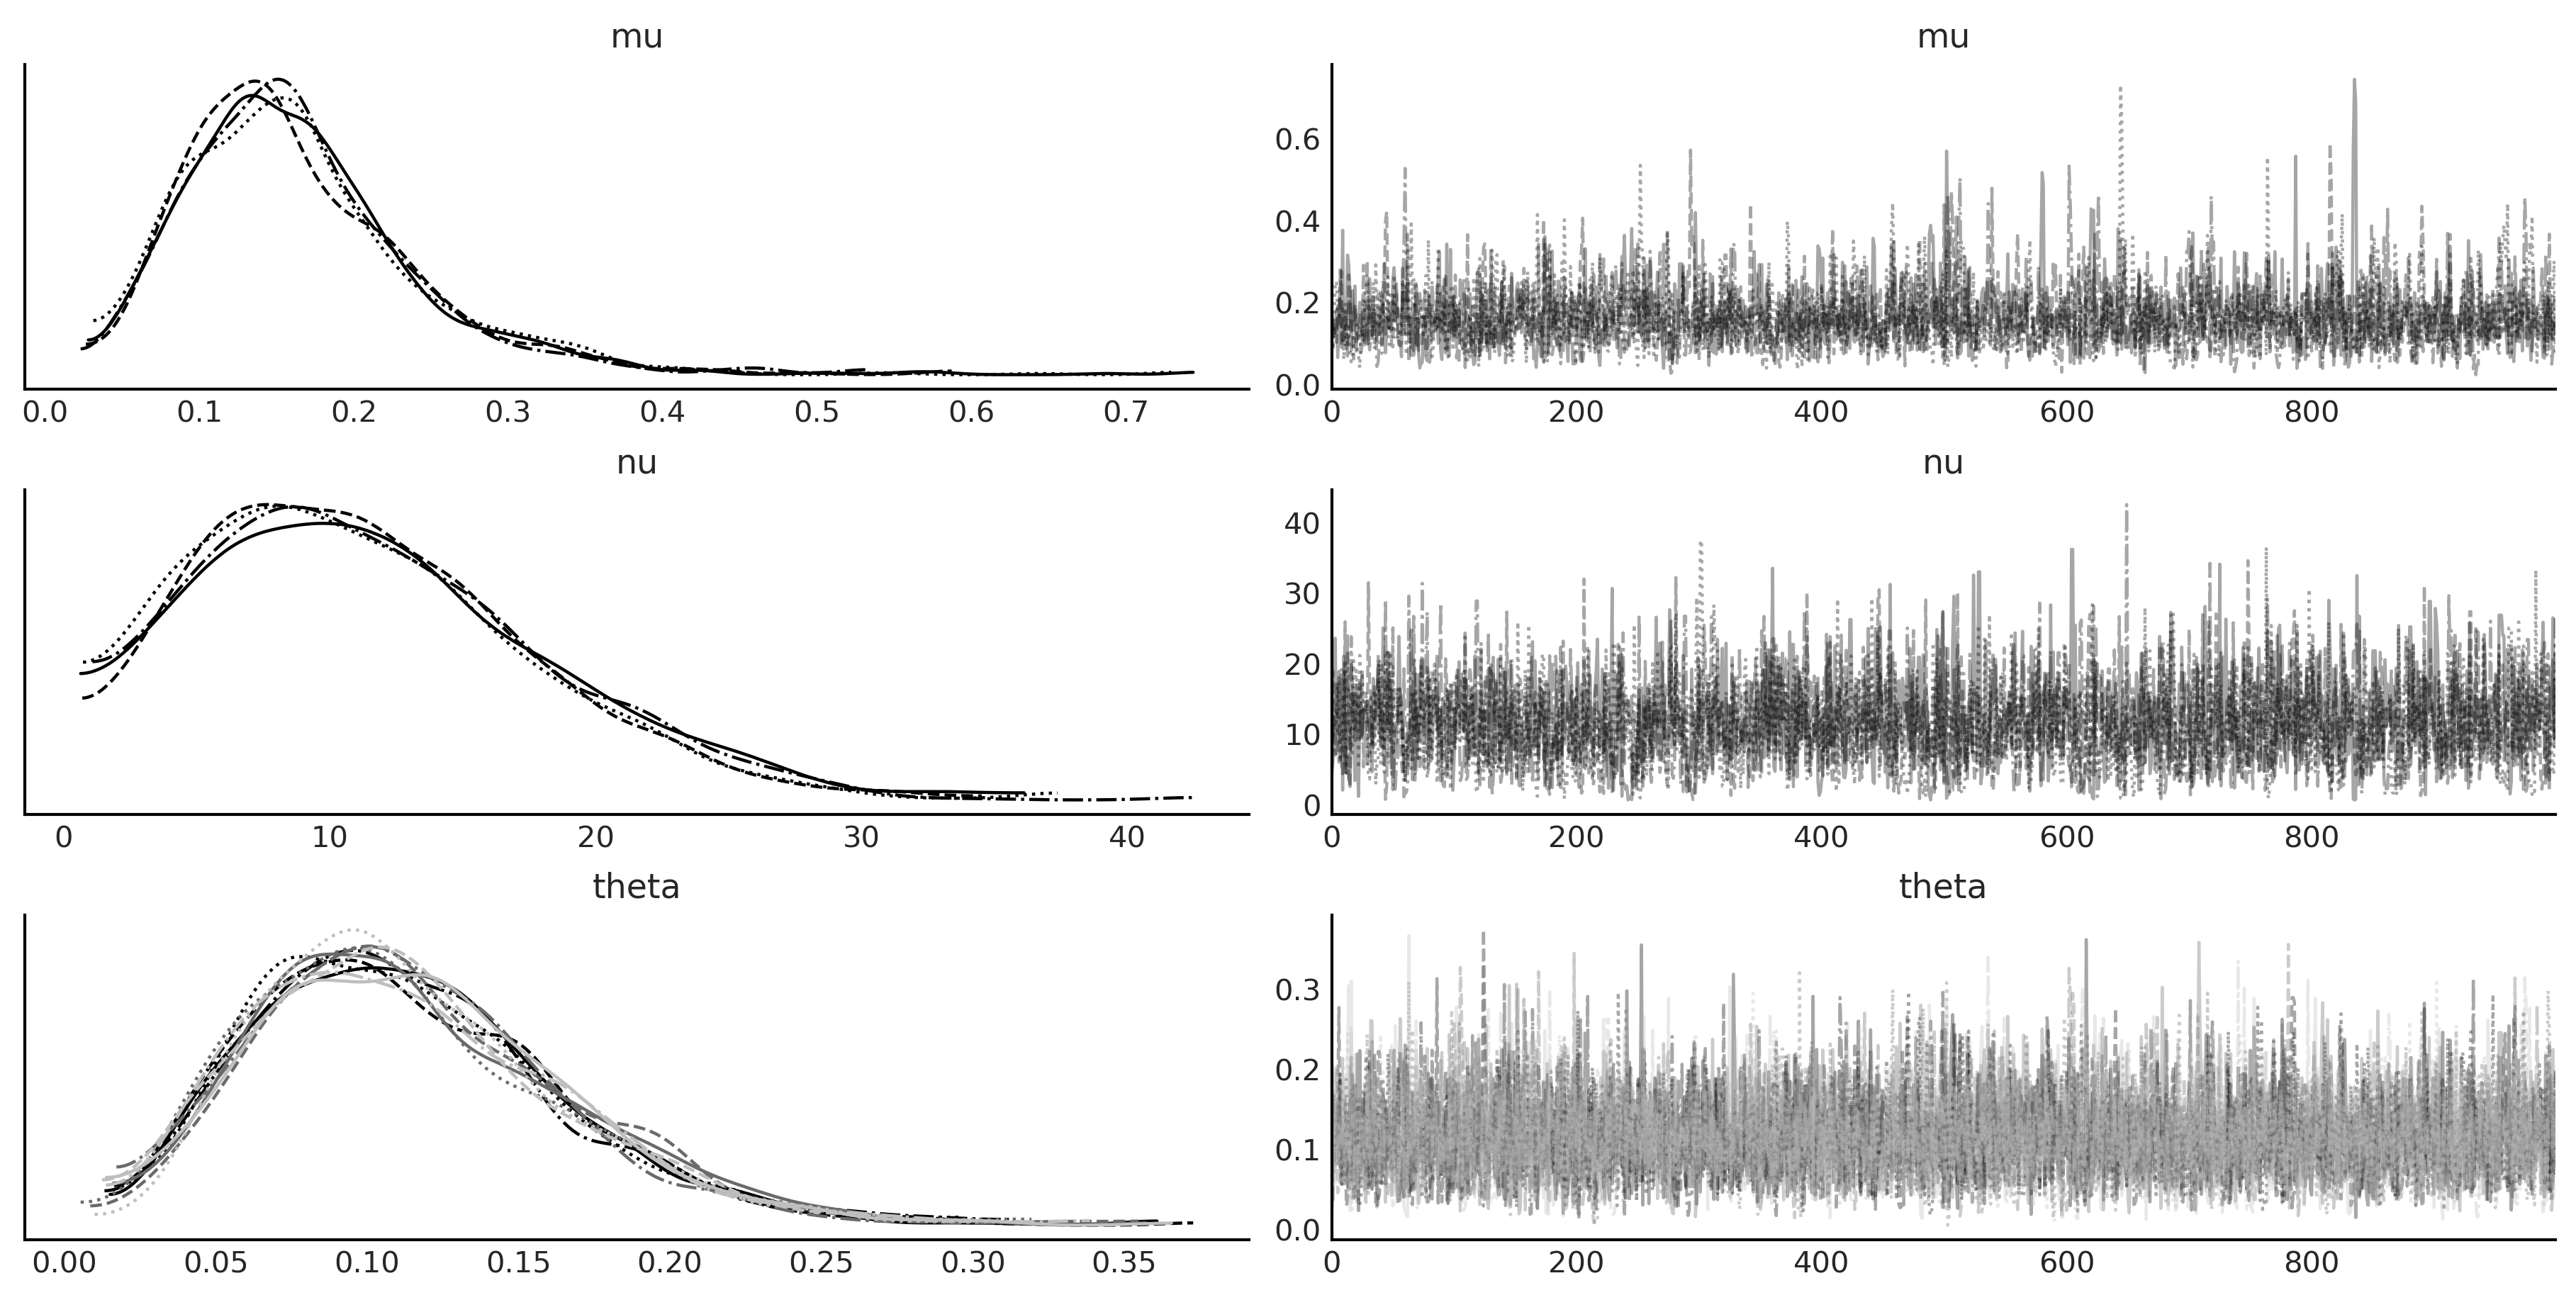

In [18]:
az.plot_trace(idata_h)
plt.show()

In [19]:
summary_g_3 = az.summary(idata_h)

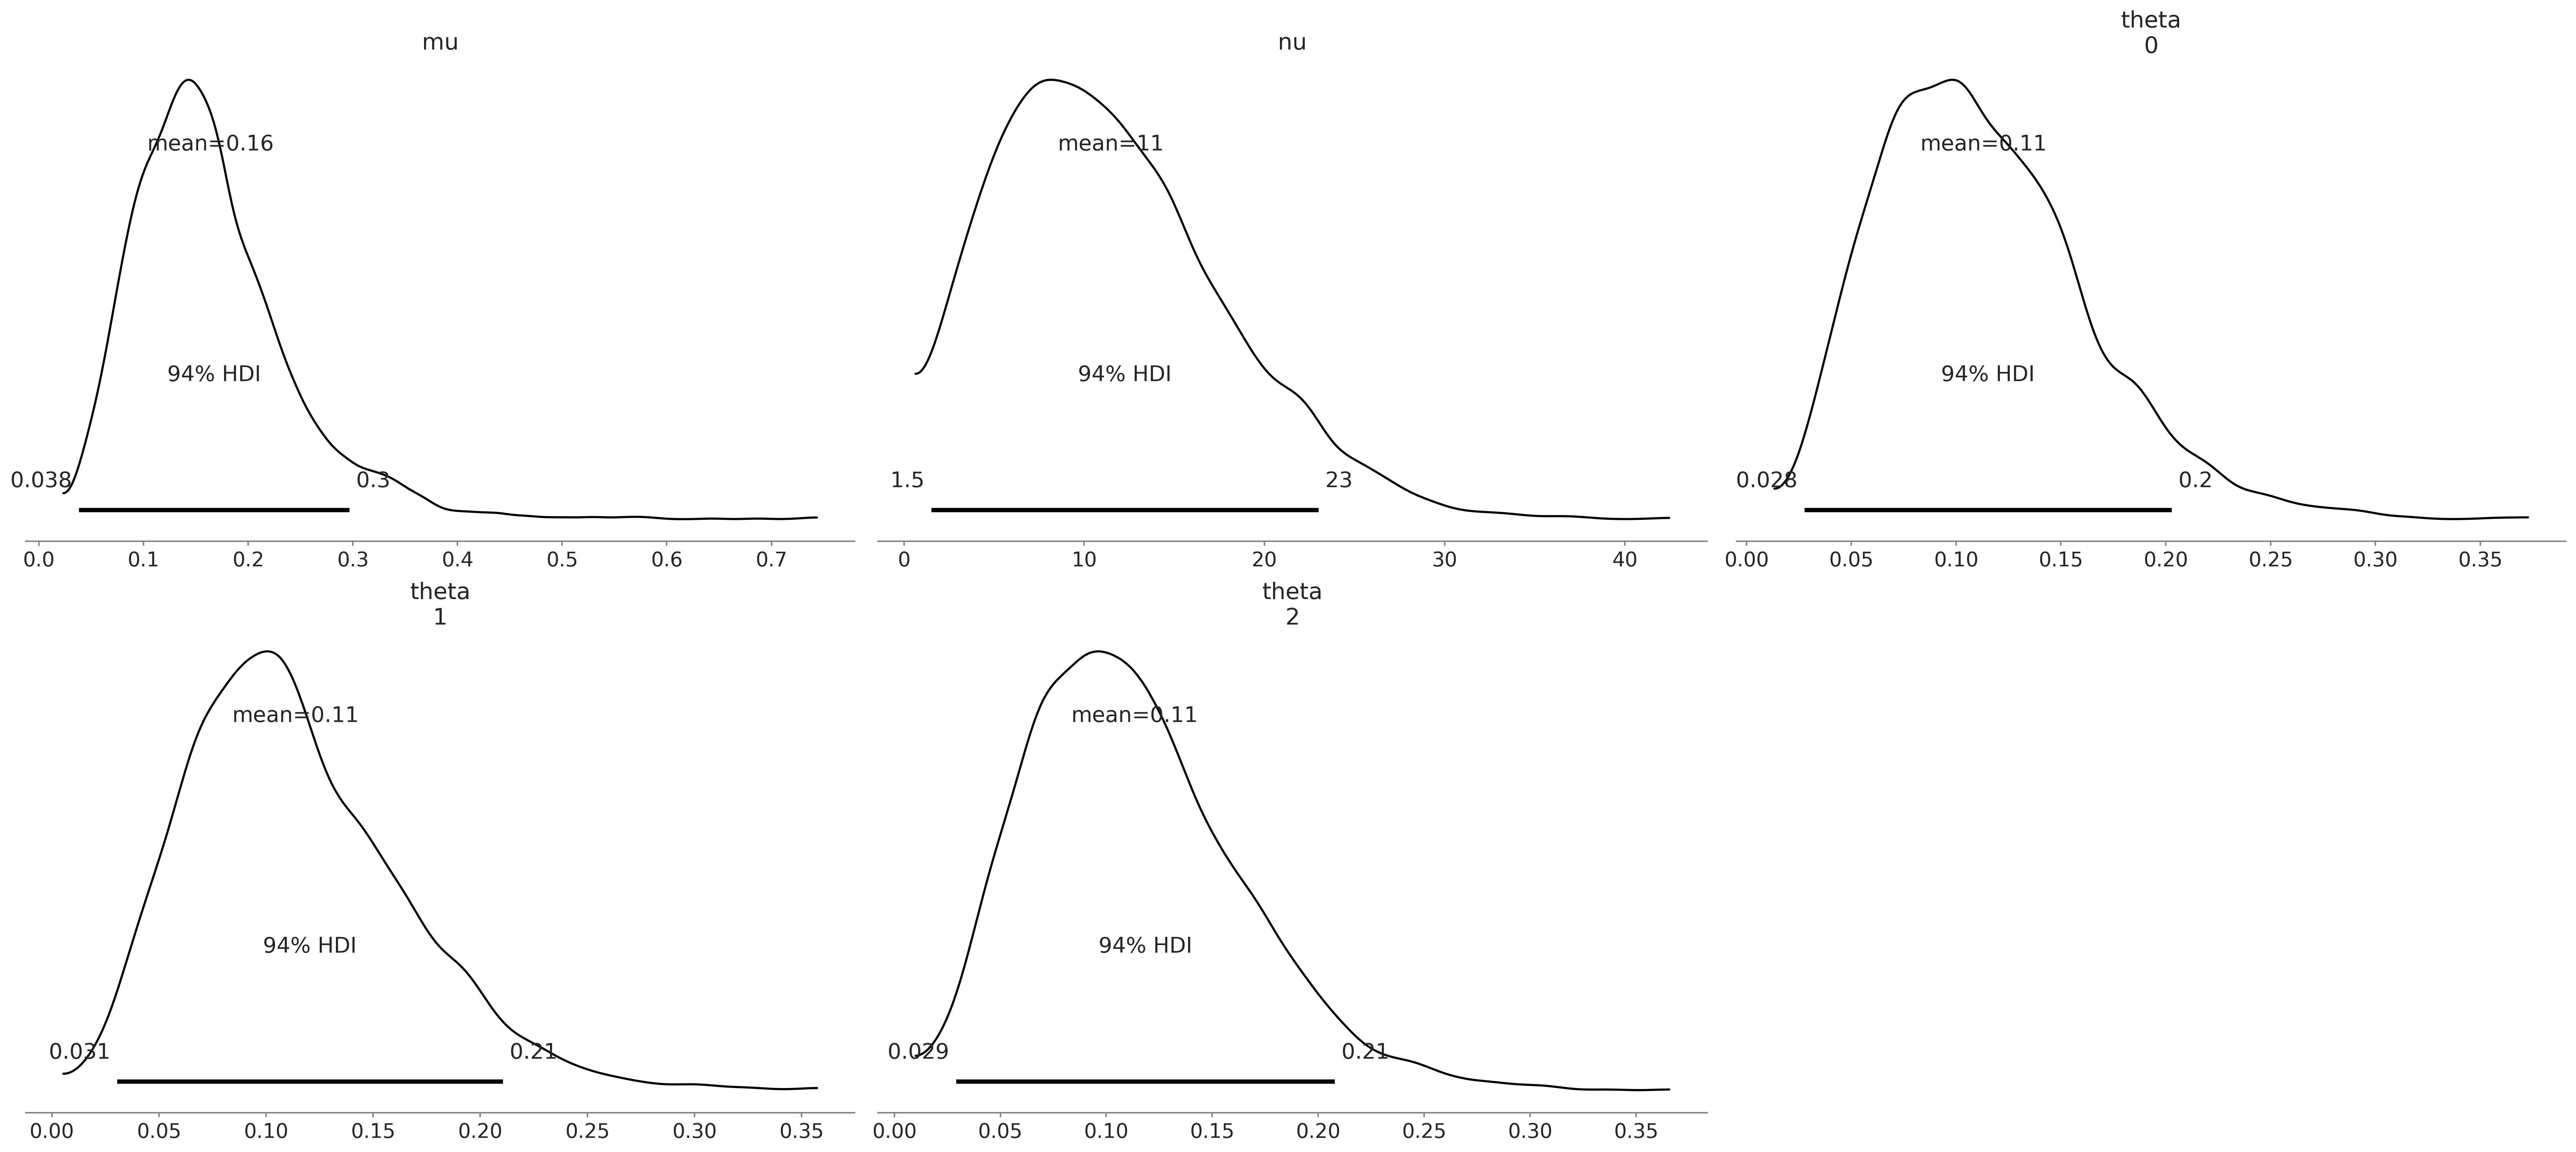

In [20]:
az.plot_posterior(idata_h)
plt.show()

In [21]:
G_samples = [18, 3, 3] # number of good samples

data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0],
                          [G_samples[i], N_samples[i] - G_samples[i]]))

# Let's write the model in PyMC.
with pm.Model() as model_h:
    # hyperpriors
    mu = pm.Beta('mu', 1, 1)
    nu = pm.HalfNormal('nu', 10)

    # prior
    theta = pm.Beta('theta', mu=mu, nu=nu, shape=len(N_samples))

    # likelihood
    y = pm.Bernoulli('y', p = theta[group_idx], observed=data)

    idata_h = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


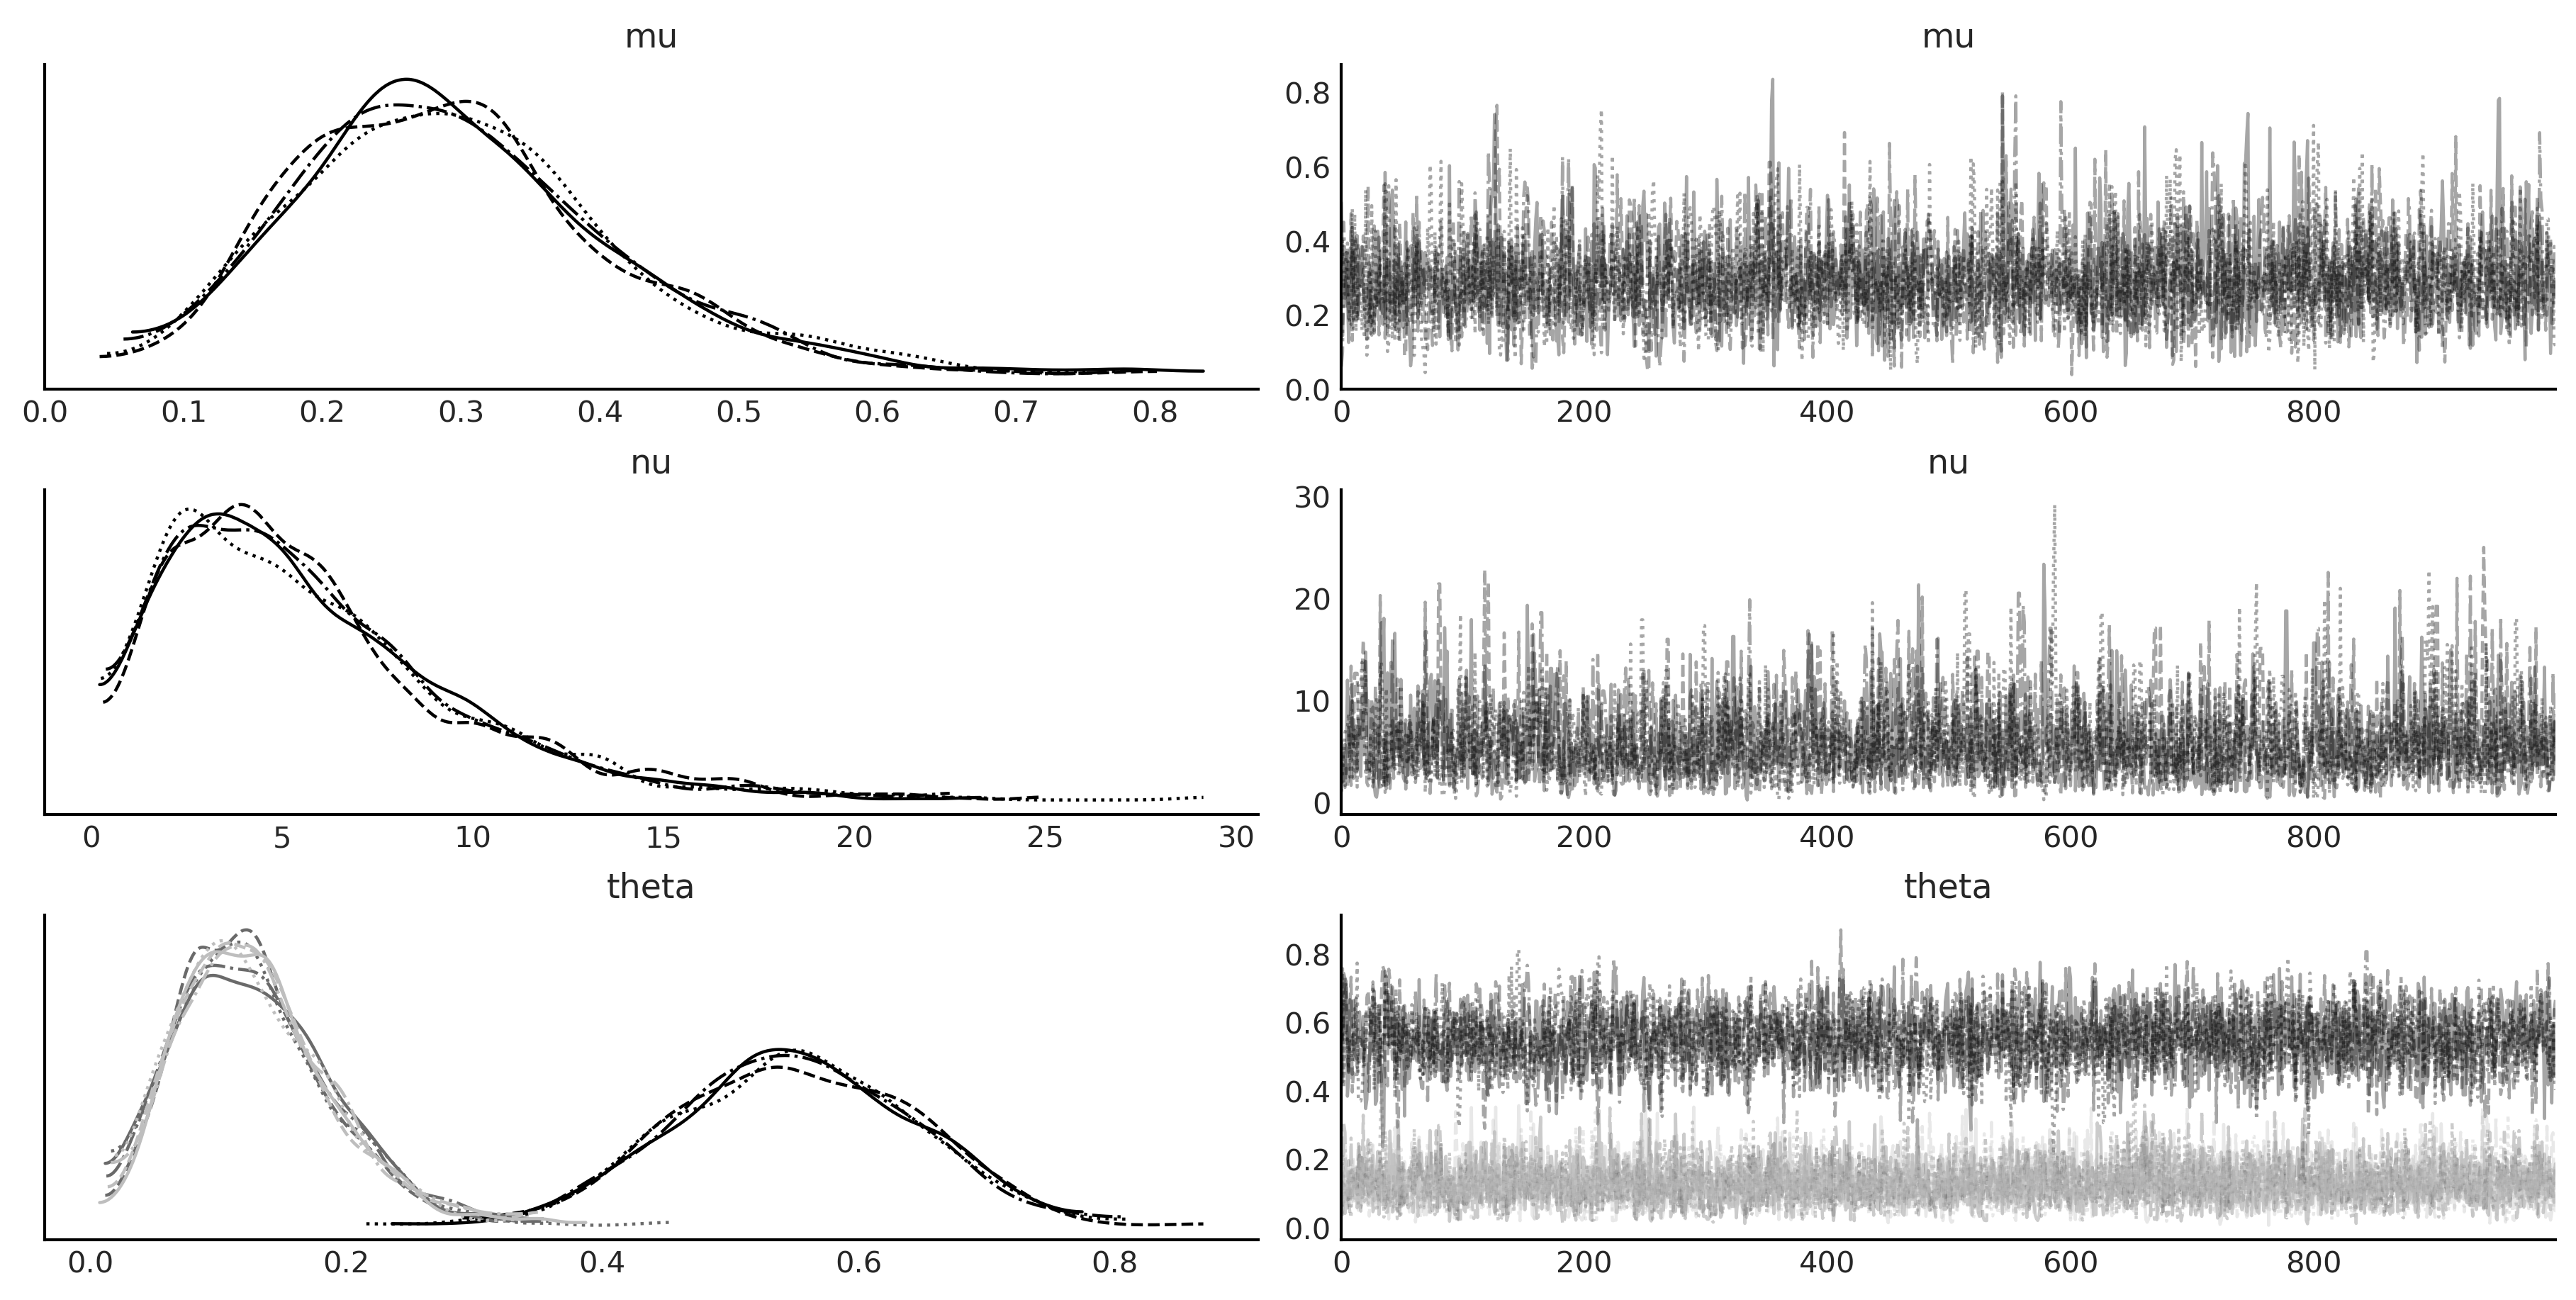

In [22]:
az.plot_trace(idata_h)
plt.show()

In [23]:
summary_g_mixed = az.summary(idata_h)

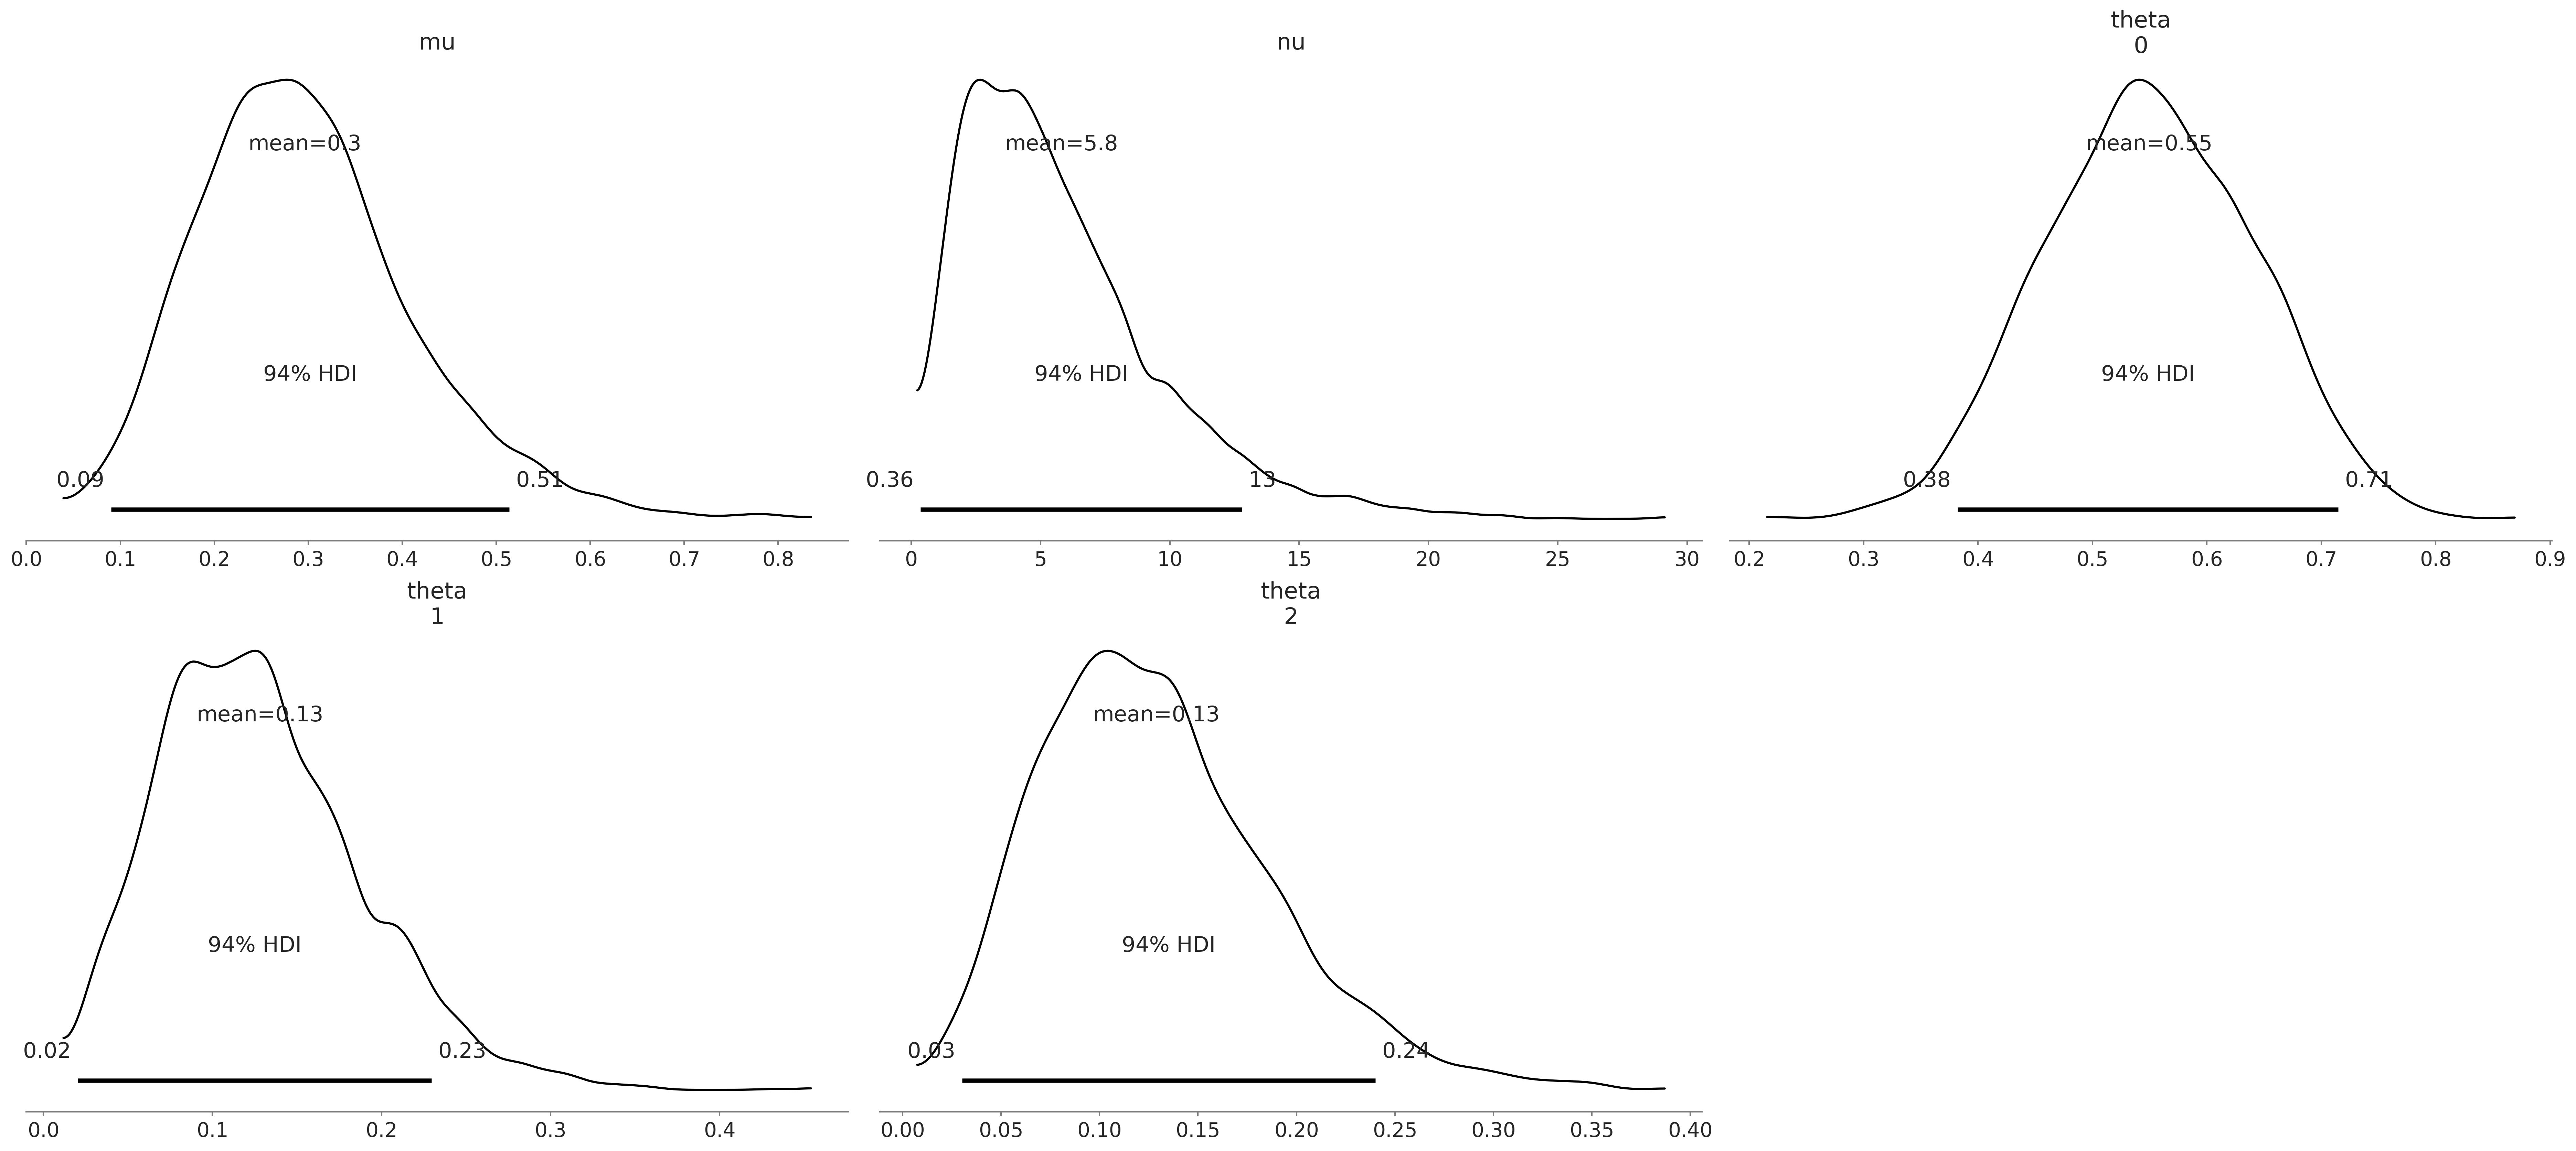

In [24]:
az.plot_posterior(idata_h)
plt.show()

In [25]:
summary_g_18

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu         0.585  0.097   0.411    0.771      0.002    0.001    3410.0   
nu        12.324  6.351   1.326   23.497      0.114    0.080    2610.0   
theta[0]   0.596  0.079   0.437    0.733      0.001    0.001    3712.0   
theta[1]   0.595  0.079   0.446    0.745      0.001    0.001    3050.0   
theta[2]   0.596  0.080   0.450    0.746      0.001    0.001    3828.0   

          ess_tail  r_hat  
mu          2767.0    1.0  
nu          1679.0    1.0  
theta[0]    2926.0    1.0  
theta[1]    2706.0    1.0  
theta[2]    2919.0    1.0

In [26]:
summary_g_3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu         0.164  0.076   0.038    0.297      0.002    0.001    2469.0   
nu        11.482  6.296   1.510   22.998      0.116    0.082    2466.0   
theta[0]   0.113  0.050   0.028    0.203      0.001    0.001    3600.0   
theta[1]   0.114  0.051   0.031    0.210      0.001    0.001    3489.0   
theta[2]   0.113  0.051   0.029    0.208      0.001    0.001    3103.0   

          ess_tail  r_hat  
mu          2328.0    1.0  
nu          2000.0    1.0  
theta[0]    2658.0    1.0  
theta[1]    2487.0    1.0  
theta[2]    2392.0    1.0

In [27]:
summary_g_mixed

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu        0.296  0.115   0.090    0.514      0.002    0.002    3210.0   
nu        5.807  3.861   0.357   12.782      0.078    0.057    2412.0   
theta[0]  0.550  0.091   0.382    0.715      0.002    0.001    3561.0   
theta[1]  0.128  0.060   0.020    0.230      0.001    0.001    2767.0   
theta[2]  0.129  0.059   0.030    0.240      0.001    0.001    3555.0   

          ess_tail  r_hat  
mu          2641.0    1.0  
nu          2422.0    1.0  
theta[0]    2918.0    1.0  
theta[1]    2080.0    1.0  
theta[2]    2317.0    1.0

If one compares $\theta$ for each of our experiments, one observes

- The three values of $\theta$ for the first two experiments are almost equal
- The three values of $\theta$ for the last experiment is

    - **Not** a mixture of the $\theta$ values for the first
      two experiments
    - **But** an "average" of the $\theta$ values for the first
      two experiments

This behavior is an example of the estimates shrinking toward the
**common** mean (and not sampling from the other means). In other
words, each group is informing all the other groups.


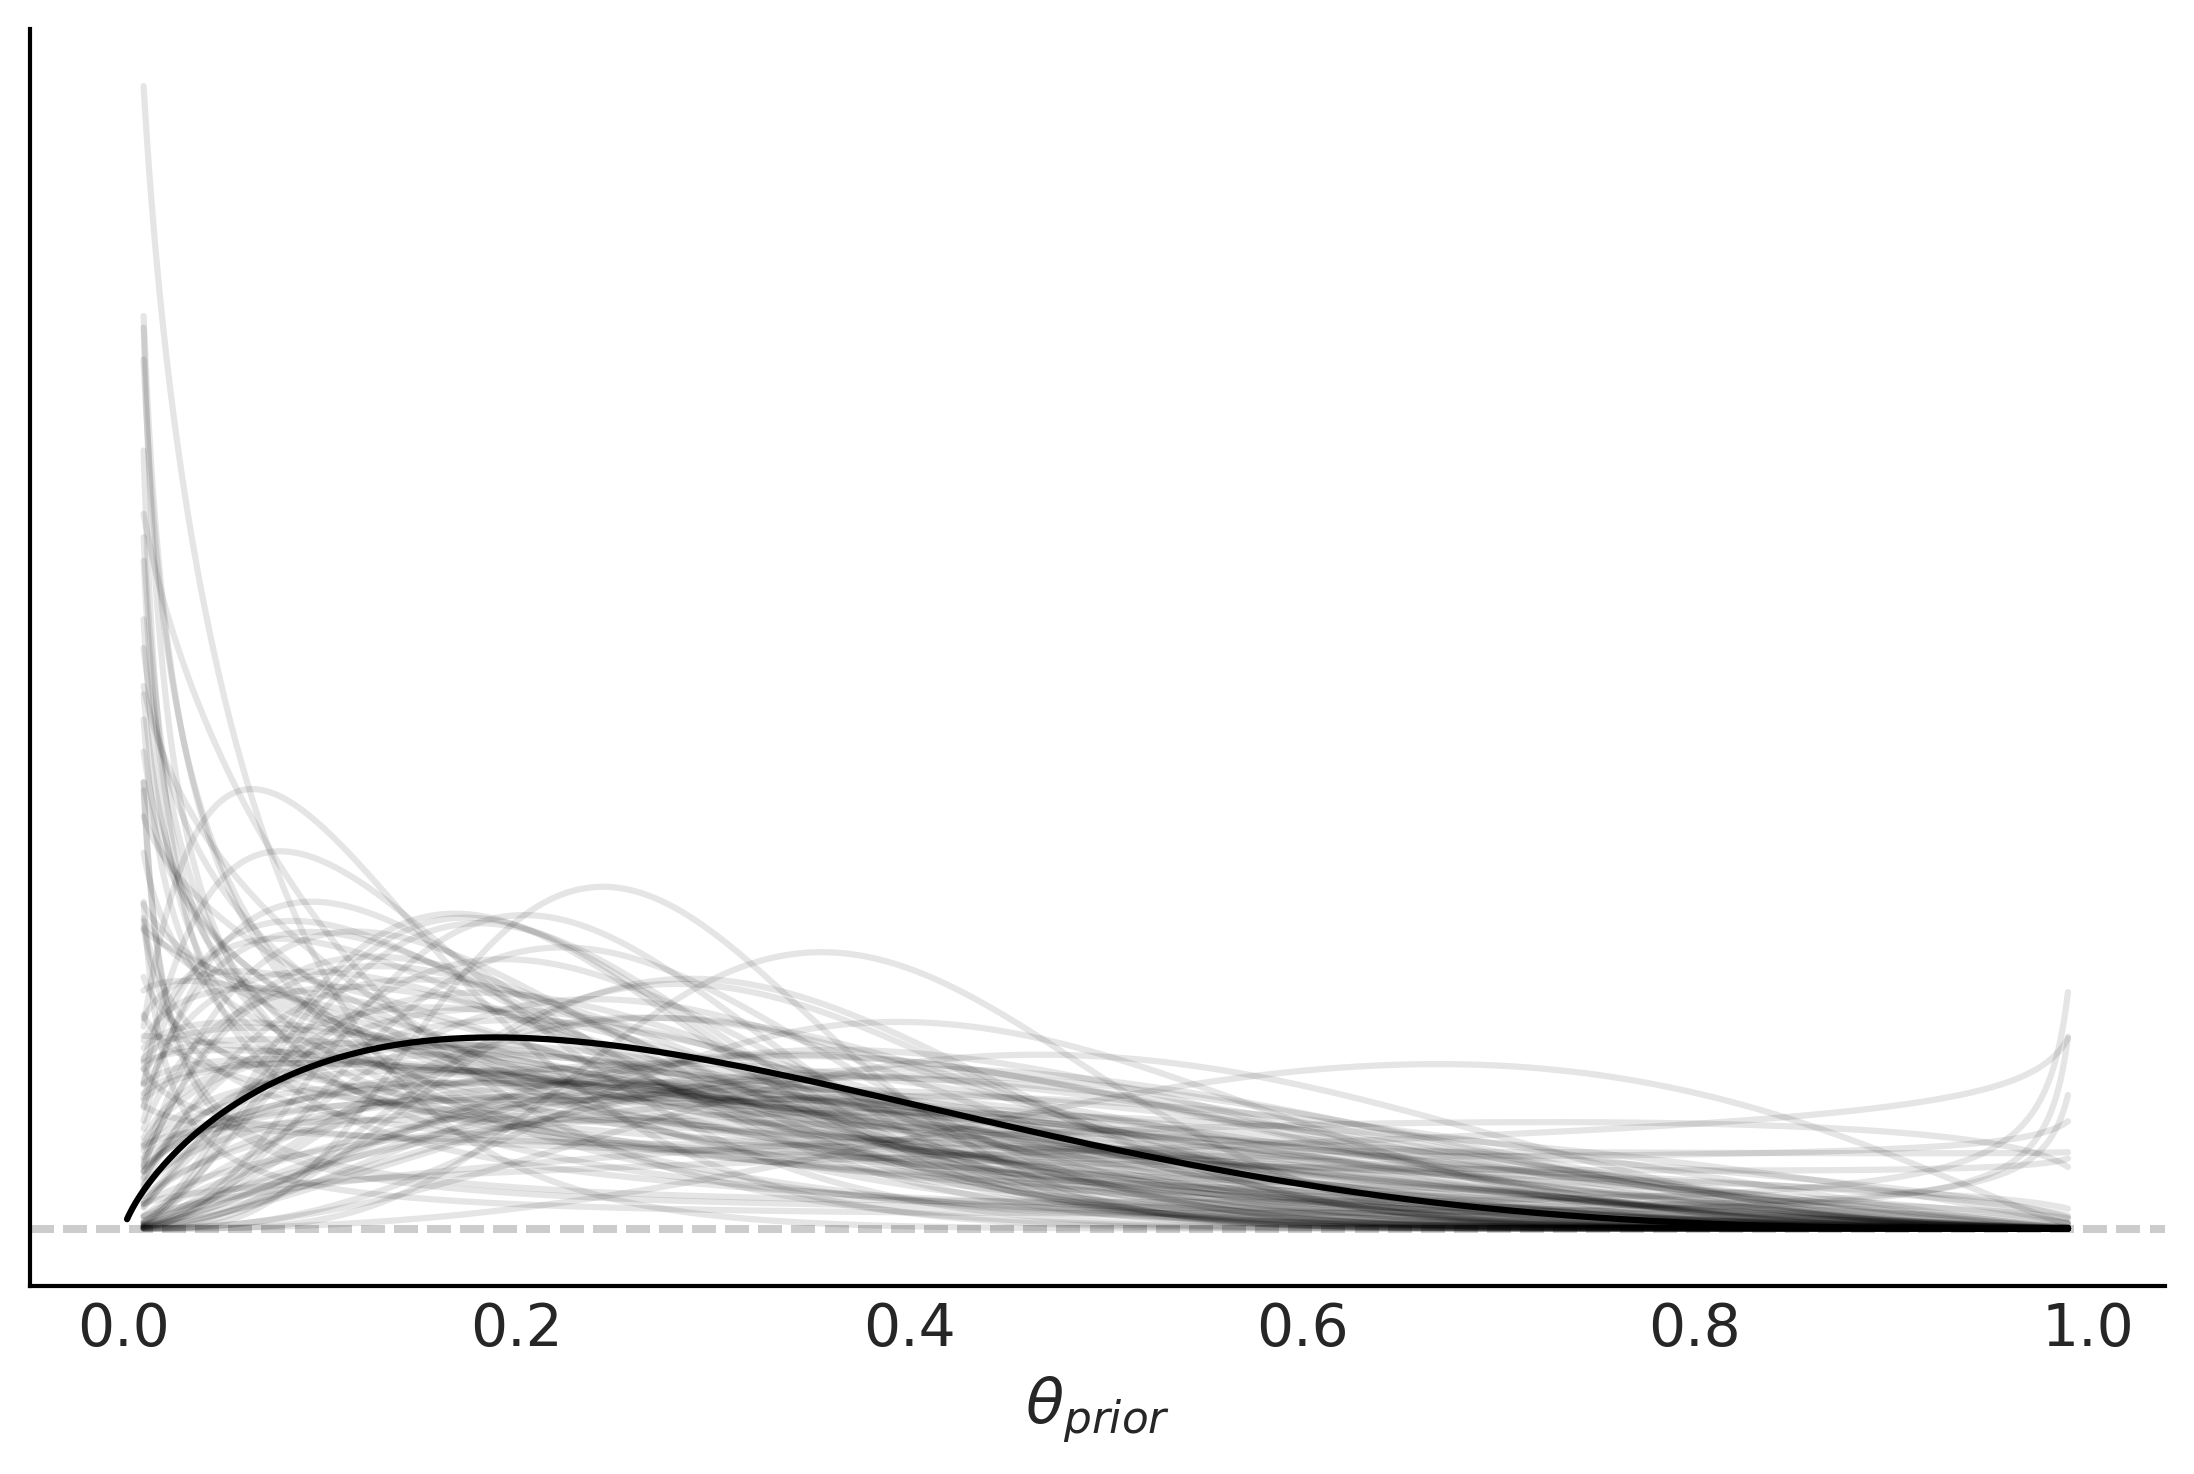

In [28]:
# Here is a plot of the posteriors for each prior
posterior = az.extract(idata_h, num_samples=100)
for sample in posterior[["mu", "nu"]].to_array().values.T:
    (pz.Beta(mu=sample[0], nu=sample[1]).
     plot_pdf(legend='', color="C0", alpha=0.1, support=(0.01, 0.99),
              moments="m"))

(pz.Beta(mu=posterior["mu"].mean().item(),
         nu=posterior["nu"].mean().item())
 .plot_pdf(legend='', color="C0", moments="m"))
plt.xlabel('$θ_{prior}$')
plt.show()

Hmm... I think I've coded everything correctly, but I see a significantly
different plot from the book. I do not understand the reason.

Why is shrinkage desirable? It contributes to more stable inferences in
a similar way that the Student's T distribution is more robust in the
presence of outliers. Introducing hyperpriors results in a more
conservative model; that is, a model that is **less** responsive
to extreme values in individual groups.

The amount of shrinkage depends on the data; a group with more data
will "pull" the estimate of other groups "harder" than a group with
fewer data points. If several groups are similar but one group is
different, the similar groups informs the others of their similarity
and reinforce a common estimate. At the same time, these similar groups
"pull" the estimates for the less similar group toward the common mean.

**Shrinkage**

In a hierarchical model, groups that share a common hyperprior are
effectively sharing information through the hyperprior. This "sharing"
produces shrinkage; that is, individual group estimates of the mean
are shrunk toward the common mean.

By partially pooling the data, we are modeling groups as some middle
ground between the groups being independent and a single big group.

Nothing prevents us from building a hierarchical model with just
two groups; however, we **prefer** to have **several** groups.
Intuitively, getting shrinkage is like assuming each group is a
single data point, and we are estimating the standard deviation
at the group level. Just as we generally do not trust an estimate
with too few data points without strong prior beliefs, we trust a
hierarchical model with two few groups less than one with many groups.

## 3.5 Hierarchies all the way up

Many data structures may by described by hierarchical descriptions
that can encompass multiple level.

- Professional football (soccer) players. Skill metrics for
    - Each player
    - The positions
    - All professional football players
- Medical research. We can categorize patients based on their
    - Demographic information
    - Disease severity
    - Other relevant factors
- Environmental science. We want to estimate the impact of a pollutant
on different habitats within the ecosystem
    - Rivers
    - Lakes
    - Forests
    - Wetlands
- Market research. We want to understand purchasing behavior based
on demographics
    - Age
    - Gender
    - Income
    - Education

We have actually collected football (soccer) statistics from different
leagues over the course of four years (2017 to 2020). Specifically, we
are interested in the goals-per-shot metric. This rate is what
statisticians usually call a _success rate_. We can estimate it with a
Binomial model where the parameter $n$ is the number of shots and the
observations $y$ is the number of of gols. This description leaves us
with an unknown value for $p$.

In previous examples, we have called the $p$ parameter $\theta$ and
have used a Beta distribution to model it. We will do the same now
but hierarchically.

Once we have created our model using PyMC, we will display a graphical
representation of the model